### Supplement 1. find non change of mind trials where the animal back off.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import os
import pickle
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

[2025-02-24 14:11:04,258][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-02-24 14:11:04,288][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [197]:
from spyglass.shijiegu.load import load_run_sessions, load_decode, load_theta_maze
from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map, TrialChoiceChangeOfMind, DecodeResultsLinear
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking
from spyglass.shijiegu.changeOfMind import (insertTrialChoiceChangeOfMind, find_turnaround_time, findProportion,
            find_trials, load_epoch_data_wrapper, find_direction, find_trials_animal, unique_stable)
from spyglass.shijiegu.helpers import interpolate_to_new_time

from spyglass.shijiegu.theta import return_skaggs_theta
import matplotlib.patheffects as PathEffects
from spyglass.spikesorting.v0 import Curation
from spyglass.shijiegu.singleUnit import get_nwb_units, electrode_unit 
from spyglass.shijiegu.ripple_add_replay import select_subset_helper,select_subset_helper_pd

In [198]:
linear_map,node_location=get_linearization_map()

[16:00:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [544]:
def find_backout_session(nwb_copy_file_name, session_name, position_name):
    log_df = pd.read_pickle( (TrialChoiceChangeOfMind() & {"nwb_file_name": nwb_copy_file_name,
                                                           "epoch":int(session_name[:2])}).fetch1("change_of_mind_info") )
    
    linear_position_info=(IntervalLinearizedPosition() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()
    
    position_info = (IntervalPositionInfo() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()
    
    backout_segments_session = []
    for t in log_df.index[:-2]:
        
        start = log_df.loc[t,'timestamp_O']
        end = log_df.loc[t+1,'timestamp_H']
        if np.isnan(start) or np.isnan(end):
            continue
        if log_df.loc[t,'change_of_mind']:
            continue
    
        trialInd = (linear_position_info.index >= start) & (linear_position_info.index <= end)
        trialInfo = linear_position_info.loc[trialInd]
        trialInfo2D = position_info.loc[trialInd]
        outerArmInd = trialInfo.track_segment_id >= 6
        trialInfo = trialInfo.loc[outerArmInd,:]
        trialInfo2D = trialInfo2D.loc[outerArmInd,:]
        
        arm_direction_t, arm_direction, all_arms_direction = find_direction(trialInfo, trialInfo2D)
        #head_direction_sign = pd.Series(arm_direction, index = arm_direction_t)
    
        trialInfo1D = interpolate_to_new_time(trialInfo, arm_direction_t)
        if len(arm_direction_t) == 0:
            continue
        movement_direction_sign = np.concatenate([[0],np.diff(trialInfo1D.linear_position)])
    
        backoff = (arm_direction * movement_direction_sign) < 0
        # animal needs to be at least 10 cm away from reward well
        well_id = np.array(trialInfo1D.track_segment_id)[0] - 5
        print('trial '+str(t),'well_id',str(well_id))
        if well_id < 1:
            continue
        
        outer_well_linear = node_location['well'+str(well_id)]
        backoff = backoff * np.abs(trialInfo1D.linear_position - outer_well_linear) >= 5
        
        backoff_pd = pd.Series(backoff, index = arm_direction_t)
    
        backout_segments = np.array(segment_boolean_series(
            backoff_pd, minimum_duration=0.5)).reshape((-1,2))
        if len(backout_segments) > 0:
            for backout_segment in backout_segments:
                trialInfo1D_segment = interpolate_to_new_time(trialInfo, backout_segment)
                if np.abs(np.diff(np.array(trialInfo1D_segment.linear_position))) < 10:
                    continue
                
                backout_segments_session.append(([nwb_copy_file_name, session_name, position_name, t],backout_segment))
    return backout_segments_session #, head_direction_sign

In [538]:
animal = 'Eliot'
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

In [ ]:
animal = 'Lewis'
dates_to_plot = ['20240102','20240103','20240104','20240105','20240106','20240107','20240108','20240109',
                 '20240110','20240113','20240114','20240115','20240116','20240117','20240118','20240119','20240120']

In [539]:
animal = 'Haydn'
dates_to_plot = ['20230603','20230604','20230605','20230606','20230607','20230608']

### 1. Load non-change-of-mind

In [540]:
nwb_copy_file_name = "haydn20230604_.nwb"

In [541]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Rev3Session1', '04_Rev3Session2', '06_Rev3Session3', '08_Rev3Session4', '10_Rev3Session5']


In [545]:
backout_segments_day = []
for epoch_ind in range(len(session_interval)):
    session_name = session_interval[epoch_ind]
    position_name = position_interval[epoch_ind]
    
    backout_segments_session = find_backout_session(nwb_copy_file_name, session_name, position_name)
    if len(backout_segments_session) > 0:
        for b in backout_segments_session:
            backout_segments_day.append(b)
    

[21:59:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[21:59:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[21:59:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[21:59:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[21:59:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.comm

In [546]:
backout_segments_day

[(['haydn20230604_.nwb', '02_Rev3Session1', 'pos 1 valid times', 35],
  array([1.68590022e+09, 1.68590023e+09])),
 (['haydn20230604_.nwb', '02_Rev3Session1', 'pos 1 valid times', 35],
  array([1.68590023e+09, 1.68590023e+09])),
 (['haydn20230604_.nwb', '02_Rev3Session1', 'pos 1 valid times', 44],
  array([1.68590045e+09, 1.68590045e+09])),
 (['haydn20230604_.nwb', '02_Rev3Session1', 'pos 1 valid times', 46],
  array([1.6859005e+09, 1.6859005e+09])),
 (['haydn20230604_.nwb', '02_Rev3Session1', 'pos 1 valid times', 57],
  array([1.68590074e+09, 1.68590075e+09])),
 (['haydn20230604_.nwb', '02_Rev3Session1', 'pos 1 valid times', 63],
  array([1.6859009e+09, 1.6859009e+09])),
 (['haydn20230604_.nwb', '02_Rev3Session1', 'pos 1 valid times', 70],
  array([1.68590105e+09, 1.68590105e+09])),
 (['haydn20230604_.nwb', '02_Rev3Session1', 'pos 1 valid times', 73],
  array([1.68590112e+09, 1.68590112e+09])),
 (['haydn20230604_.nwb', '02_Rev3Session1', 'pos 1 valid times', 73],
  array([1.68590112e+0

In [547]:
decode_options = {}
decode_options["encoding_set"] = '2Dheadspeed_above_4' #'2Dheadspeed_above_4_andlowmua'#'2Dheadspeed_above_4'
decode_options["classifier_param_name"] = 'default_decoding_gpu_4armMaze'
decode_options["decode_threshold_method"] = 'MUA_0SD'
decode_options["causal"] = False
decode_options["likelihood"] = False

In [563]:
bi = 4
backout_segment = backout_segments_day[bi]
plottimes = (backout_segment[1][0]-1, backout_segment[1][1]+3)
(nwb_copy_file_name, session_name, position_name, t) = backout_segments_day[bi][0]
print(plottimes)
print(nwb_copy_file_name, session_name, position_name, 'trial '+str(t))

(1685900743.2385535, 1685900748.0865529)
haydn20230604_.nwb 02_Rev3Session1 pos 1 valid times trial 57


In [564]:
log_df = pd.read_pickle( (TrialChoiceChangeOfMind() & {"nwb_file_name": nwb_copy_file_name,
                                                           "epoch":int(session_name[:2])}).fetch1("change_of_mind_info") )
    
linear_position_info=(IntervalLinearizedPosition() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()
    
position_info = (IntervalPositionInfo() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()

# 3. load decode
decode = load_decode(nwb_copy_file_name,session_name,
                     decode_options["classifier_param_name"],decode_options["encoding_set"])
# 4. load spikes
curation_id = 0
from spyglass.shijiegu.singleUnit_sortedDecode import place_field_direction, color_cells_by_place_direction

(cells, smoothed_placefield, placefield_peak,
        spike_count_by_arm_direction, time_spent_by_arm_direction, betaPdfs, means) = place_field_direction(nwb_copy_file_name,
                                                                                session_name,position_name,
                                                                                curation_id = curation_id)
cell_color = color_cells_by_place_direction(cells, placefield_peak, spike_count_by_arm_direction)

sort_group_ids = np.unique((Curation() & {'nwb_file_name': nwb_copy_file_name,
                                              "curation_id":1}).fetch("sort_group_id"))

nwb_units_all = get_nwb_units(
            nwb_copy_file_name,session_name,sort_group_ids,curation_id = curation_id)

[22:06:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[22:06:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[22:06:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[22:06:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[22:06:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearizatio

In [565]:
import scipy.signal as ss
#theta_df, pos1d, pos2d = return_skaggs_theta(nwb_copy_file_name,position_name,session_name,
#                                             nwb_units_all,cells)
#theta_df.index.name='time'
#theta_df=xr.Dataset.from_dataframe(theta_df)

theta_xr = load_theta_maze(nwb_copy_file_name,session_name)
theta_xr = theta_xr.assign(phase0=('time',np.angle(ss.hilbert(theta_xr[0]))))
#theta_xr = theta_xr.assign(phase1=('time',np.angle(ss.hilbert(theta_xr[1]))))
theta_df = theta_xr.to_dataframe()

In [566]:
results_subset = select_subset_helper(decode,plottimes)
head_direction_sign_subset = select_subset_helper_pd(head_direction_sign,plottimes)
#theta_xr_subset = select_subset_helper(theta_xr,plottimes)
#theta_df = theta_xr_subset.to_dataframe()

posterior_position_subset=results_subset.causal_posterior.sum(
        dim='state')
theta_subset = select_subset_helper(theta_xr,plottimes) 
theta_subset = theta_subset.to_dataframe()

linear_position_xr=xr.Dataset.from_dataframe(linear_position_info)
linear_position_subset= select_subset_helper(linear_position_xr,plottimes)


cells_fired = []
for cell in cells:
    (e,u) = cell
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)
    spike_times = nwb_units.loc[u].spike_times
    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]
    if len(spike_times) > 0:
        cells_fired.append(cell)


Text(0.5, 1.0, 'head orientation')

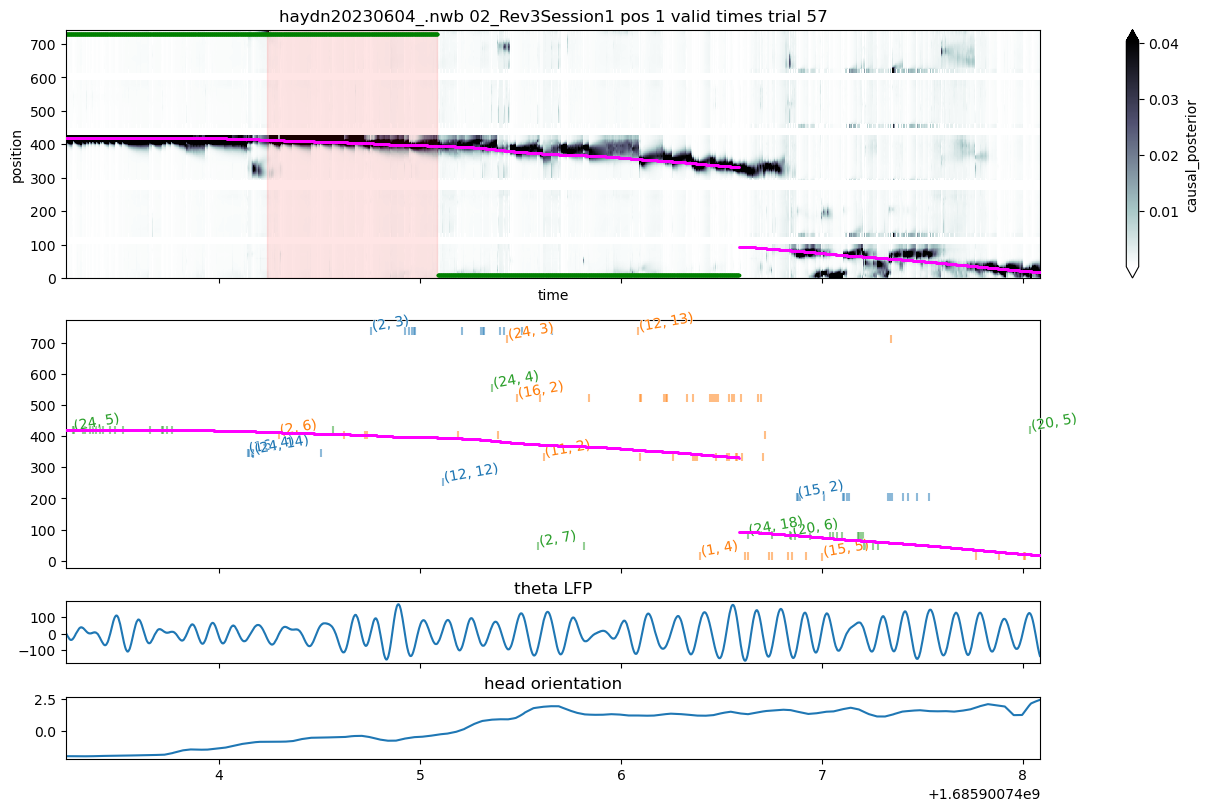

In [567]:
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True,
                             constrained_layout=True,gridspec_kw={"height_ratios": [2,2,0.5,0.5]})
posterior_position_subset.plot(x='time', y='position', ax=axes[0], rasterized=True, robust=True, cmap='bone_r')
for cell in cells_fired:
    e = cell[0]
    u = cell[1]
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)

    spike_times = nwb_units.loc[u].spike_times
    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]

    if cell_color[(e,u)] == "k":
        cell_color[(e,u)] = "C2"

    axes[1].scatter(spike_times, np.zeros(len(spike_times)) + placefield_peak[(e,u)],
                    rasterized=True, marker='|', color = cell_color[(e,u)],alpha = 0.5)
    if len(spike_times) > 0:
        txt = axes[1].text(spike_times[0],placefield_peak[(e,u)],str((e,u)),rotation = 10, color = cell_color[(e,u)])
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w',alpha = 0.8)])

theta_d0=np.array(np.array(theta_subset[0])).astype('int32').T
#theta_d1=np.array(np.array(theta_subset[1])).astype('int32').T
theta_t=np.array(theta_subset.index)
axes[2].plot(theta_t,theta_d0)
#axes[2].plot(theta_t,theta_d1)
axes[2].set_title('theta LFP')


axes[0].scatter(linear_position_subset.time,
                np.array(linear_position_subset.linear_position),
                s=1, color='magenta', zorder=10)

axes[1].scatter(linear_position_subset.time,
                np.array(linear_position_subset.linear_position),
                s=1, color='magenta', zorder=10)
axes[0].axvspan(backout_segment[1][0], backout_segment[1][1], color = "red", alpha = 0.1)


trialInd = (linear_position_info.index >= plottimes[0]) & (linear_position_info.index <= plottimes[1])
trialInfo = linear_position_info.loc[trialInd]
trialInfo2D = position_info.loc[trialInd]
        
arm_direction_t, arm_direction, all_arms_direction = find_direction(trialInfo, trialInfo2D)
head_direction_sign = pd.Series(arm_direction, index = arm_direction_t)

axes[0].scatter(head_direction_sign.index,
        (head_direction_sign + 1) * 360 + 10, #so the top line is at 700
        s = 3, c = 'green')
axes[0].set_title(nwb_copy_file_name + ' ' + session_name + ' ' + position_name + ' ' + 'trial '+str(t))
axes[3].plot(trialInfo2D.index, trialInfo2D.head_orientation)
axes[3].set_title("head orientation")